## Import Libraries

In [16]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline


## Load the Data

In [17]:
df = pd.read_csv("final_data.csv")

In [18]:
df.shape

(10754, 22)

In [19]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [20]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [21]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [22]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [23]:
df.drop('player', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('goals conceded', axis=1, inplace=True)
df.drop('clean sheets', axis=1, inplace=True)

In [24]:
# Convert categorical variables using OneHotEncoding
categorical_features = ['team', 'position']
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'minutes played', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']

In [25]:
# Calculate the frequency of each 'team'
type_counts = df['team'].value_counts()
# Filter 'team' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 20].index)]

In [26]:
df.shape

(10736, 18)

In [27]:
# Calculate the frequency of each 'position'
position_counts = df['position'].value_counts()
# Filter 'position' values that appear 10 or more times
df = df[df['position'].isin(position_counts[position_counts >=30].index)]

In [28]:
df.shape

(10736, 18)

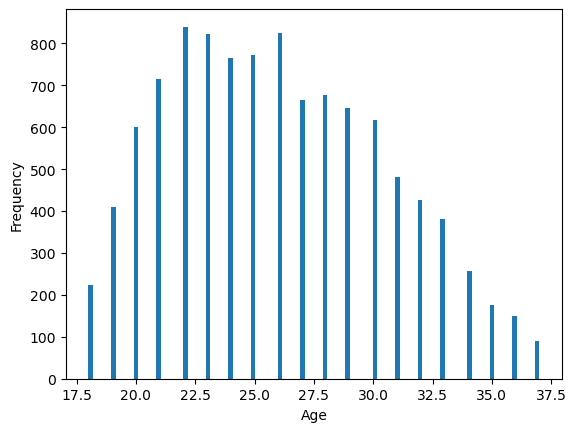

In [29]:
df = df[df['age']>=18]
df = df[df['age']<=37]
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.hist(df['age'], bins=100)
plt.show()

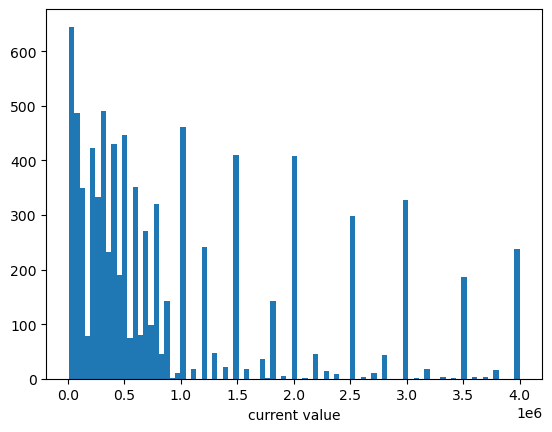

In [30]:
df = df[df['current_value'] > 2000]
df = df[df['current_value'] <= 4000000]
plt.xlabel('current value')
plt.hist(df['current_value'], bins= 85)
plt.show()

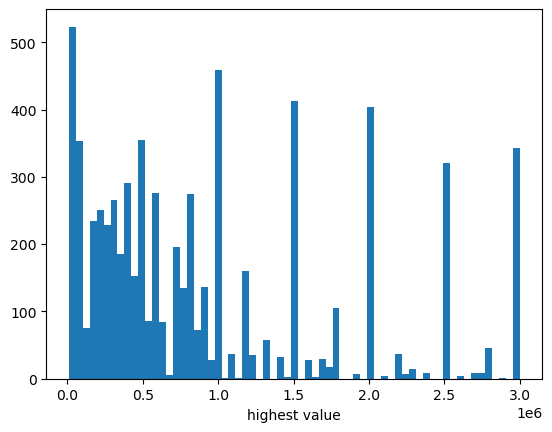

In [31]:
df = df[df['highest_value'] > 2000]
df = df[df['highest_value'] <= 3000000]
plt.xlabel('highest value')
plt.hist(df['highest_value'], bins= 65)
plt.show()

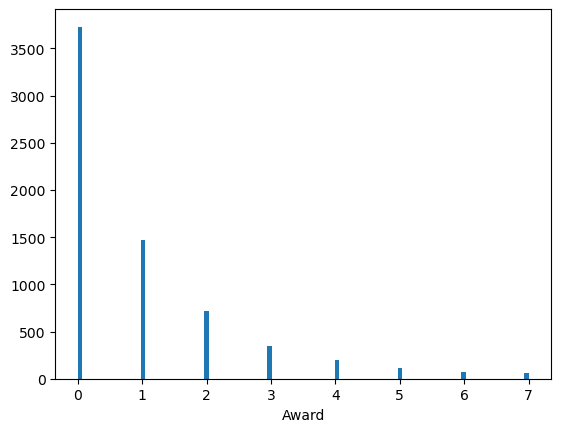

In [32]:
df = df[df['award'] <= 7]
plt.hist(df['award'], bins=100)
plt.xlabel('Award')
plt.show()

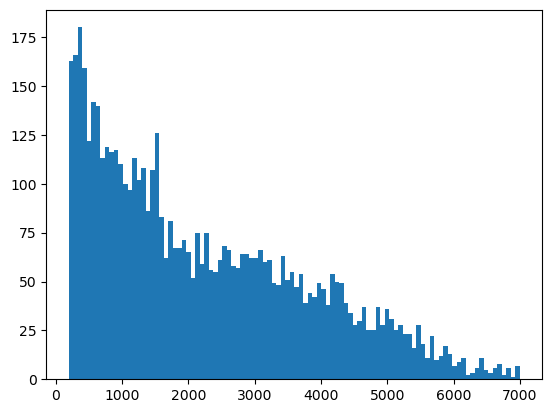

In [33]:
df= df[df['minutes played'] >= 200 ]
df= df[df['minutes played'] <= 7000]
plt.hist(df['minutes played'], bins=100)
plt.show()

In [34]:
df.shape

(5564, 18)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [35]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
8,Manchester United,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,2758,47,13,0,2000000,2000000,2,0
20,Manchester United,midfield-CentralMidfield,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,2788,0,0,1,800000,800000,3,0


In [36]:
categorical_features

['team', 'position']

In [37]:
df.shape


(5564, 18)

#### 3. Feature selection


In [38]:

selected_features = ['age', 'goals', 'minutes played', 'current_value', 'highest_value']

In [39]:
df = df[selected_features]
df.head()

,age,goals,minutes played,current_value,highest_value
8,21.0,0.000000,2758,2000000,2000000
20,20.0,0.129125,2788,800000,800000
21,18.0,0.153759,3512,800000,800000
55,25.0,0.000000,5867,2000000,2000000
83,30.0,0.000000,644,600000,2000000


#### 4. Prepare train and test data

In [40]:
# Prepare data
X = df

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X.shape

(5564, 5)

## Buliding the Model

In [42]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 2

In [43]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [44]:
distances[:,min_samples-1]

array([0.22897289, 0.2923289 , 0.37057383, ..., 0.19304876, 0.25175194,
       0.00125451])

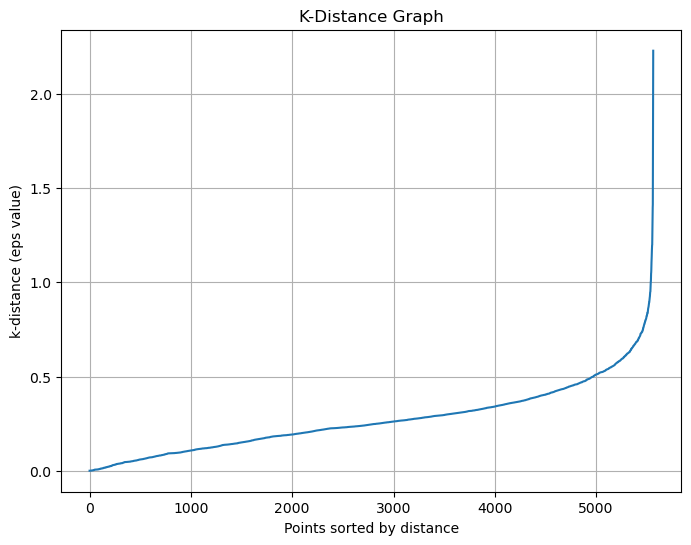

In [45]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [46]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 1 # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train and Test the Model

In [48]:
# Fit the model on the training data
clusters = dbscan.fit_predict(X_scaled)

## Evaluating the Model 

In [49]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.11430257112308635

In [50]:
X.head(2)

,age,goals,minutes played,current_value,highest_value
8,21.0,0.000000,2758,2000000,2000000
20,20.0,0.129125,2788,800000,800000


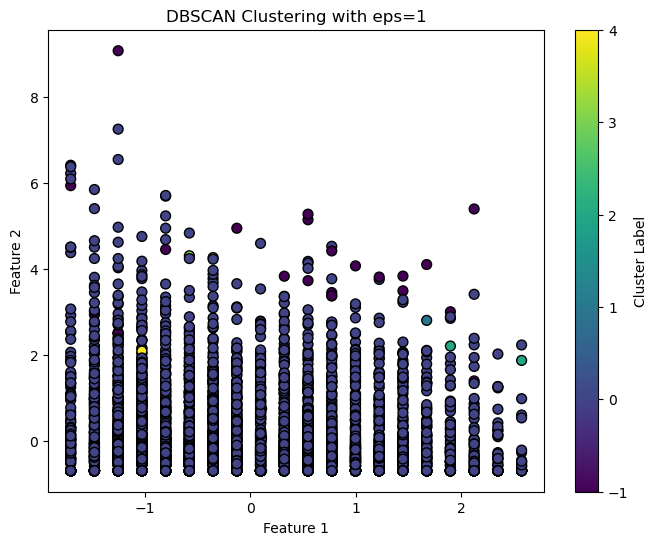

In [51]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [52]:
X['dbscan'] = clusters

In [53]:
X['dbscan'].value_counts()

dbscan
 0    5531
-1      25
 1       2
 2       2
 3       2
 4       2
Name: count, dtype: int64

<Axes: xlabel='current_value', ylabel='age'>

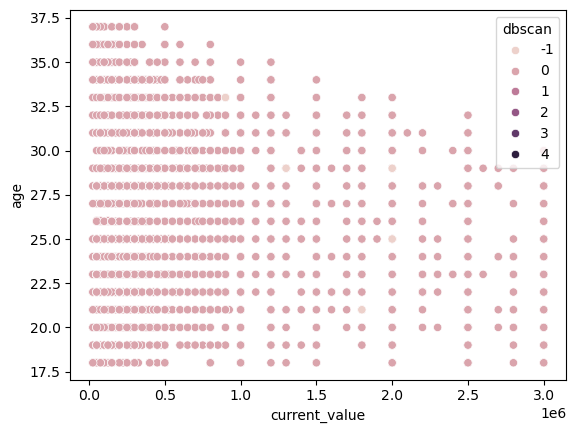

In [54]:
sns.scatterplot(data = X , x = 'current_value', y = 'age', hue = 'dbscan')

<Axes: xlabel='current_value', ylabel='goals'>

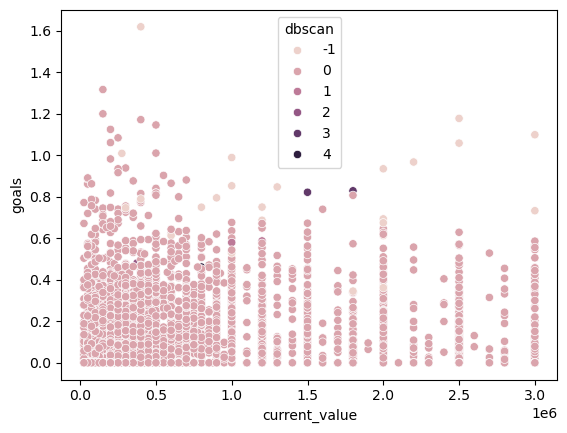

In [59]:
sns.scatterplot(data = X , x = 'current_value', y = 'goals', hue = 'dbscan')

<Axes: xlabel='current_value', ylabel='minutes played'>

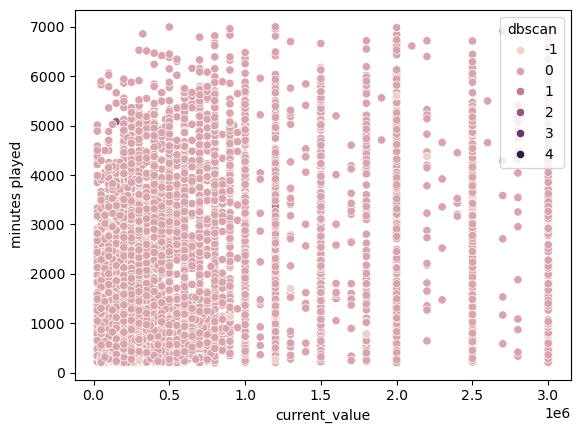

In [58]:
sns.scatterplot(data = X , x = 'current_value', y = 'minutes played', hue = 'dbscan')